## Goodreads Book Recommender

#### Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

[Part 0: Preprocessing](#part-0-preprocessing)
- [0.1 - Load and Prepare Data](#01---load-and-prepare-data)
- [0.1 - Write Functions to Process Recommendations](#02---write-functions-to-process-recommendations)

[Part 1: Collaborative Filtering Based on Reader Similarity with KNN](#part-1---collaborative-filtering-based-on-reader-similarity-with-knn)
- [1.1 - Find Similar Readers](#11---find-similar-readers)
- [1.2 - Generate Recommendations](#12---generate-recommendations)


[Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization](#part-2---collaborative-filtering-based-on-predicted-ratings-with-matrix-factorization)
- [2.1 - Factorize User-Rating Matrix with SVD](#21---factorize-user-rating-matrix-with-svd)
- [2.2 - Generate Recommendations by Predicting Ratings](#22---generate-recommendations-by-predicting-ratings)
- [2.3 - Matrix Factorization with Gradient Descent](#23-matrix-factorization-with-gradient-descent)

## Part 0: Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

In [2]:
# Set global variable of "sparse" or "dense"
# "sparse" will have user-item matrix with all books, "dense" only those in df_books
SPARSITY = "dense" 

# Choose K for small med and large neighborhoods
SM, MD, LG = 150, 750, 2000

# For titles in my_books that don't perfectly match df_books and can't be auto-matched
titles_to_replace = {
    "Children of Time (Children of Time #1)":"Children of Time",
    "King Leopold's Ghost: A Story of Greed, Terror, and Heroism in Colonial Africa":"King Leopold's Ghost",
    "Why We Love Dogs, Eat Pigs, and Wear Cows: An Introduction to Carnism":"Why We Love Dogs, Eat Pigs, and Wear Cows: An Introduction to Carnism: The Belief System That Enables Us to Eat Some Animals and Not Others",
    "Astrophysics for People in a Hurry (Astrophysics for People in a Hurry Series)":"Astrophysics for People in a Hurry",
    "Man-Eaters Of Kumaon":"The Temple Tiger and More Man-Eaters of Kumaon",    
}

### 0.1 - Load and Prepare Data

In [3]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [4]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [5]:
# Create df_reviews that is less sparse than original
if SPARSITY == "dense":
    in_df_books = book_index["book_id"].isin(df_books["book_id"])
    book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
    df_reviews = df_reviews[:, in_df_books]
print(f"User-Item Matrix: {df_reviews.shape[0]:,} readers by {df_reviews.shape[1]:,} books")    

User-Item Matrix: 245,119 readers by 315,354 books


In [6]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")
my_books["Title"].replace(titles_to_replace, inplace=True)

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# First match on book_id
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="inner", on="book_id", suffixes=["_mb","_dfb"]
            ).rename(columns={"title_dfb":"title"}).drop("title_mb", axis=1)
print(f"Matching on book_id: {my_books_1.shape[0]}")

# Next match on title
my_books_2 = pd.merge(
    my_books[~my_books["book_id"].isin(my_books_1["book_id"])], # not matched on id
    df_books[["book_id", "title", "ratings_count", "avg_rating"]], 
    how="inner", on="title", suffixes=["_mb","_dfb"]
    ).sort_values(["title", "ratings_count"], ascending=False)\
     .drop_duplicates(subset=["title"])\
     .rename(columns={"book_id_dfb":"book_id"})
print(f"Matching on title: {my_books_2[~my_books_2['book_id'].isin(my_books_1['book_id'])].shape[0]}")

# Concat matching on book_id and matching on title
my_books_3 = pd.concat([my_books_1, my_books_2[["book_id", "rating", "title"]]])\
               .drop_duplicates(subset="title")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

# Reshape to sparse matrix dimensions
my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 171
Matching on book_id: 83
Matching on title: 24
Total matches: 107, 62.57% of total


In [7]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [8]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#(?:[2-9]|[1-9]\d+)"
    regex2 = r"Vol. (?:[0-9]|[1-9]\d+)"
    regex3 = r"Volume (?:[0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings, dists

In [9]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=100, n_recs=20, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [10]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [11]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.9,                    
                    linestyle=(0, (1,1)),
                    linewidth=2.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

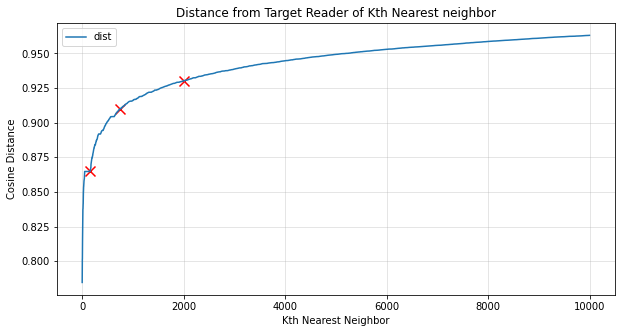

In [12]:
# Take a very large neighborhood to see how reader similarity decreases with K
n, t, dists = find_neighbors(10000, target, df_reviews_norm, book_index, df_books)

# Plot distance by kth closest neighbor
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(dists.T).rename(columns={0:"dist"})[1:10000].plot(ax=ax)
plt.title("Distance from Target Reader of Kth Nearest neighbor")
plt.xlabel("Kth Nearest Neighbor")
plt.ylabel("Cosine Distance")
ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
plt.scatter(SM, dists[0,SM], color="red", marker="x", s=100)
plt.scatter(MD, dists[0,MD], color="red", marker="x", s=100)
plt.scatter(LG, dists[0,LG], color="red", marker="x", s=100)
plt.show()

In [13]:
# Perform KNN on user rating matrix
sm_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        SM, target, df_reviews, book_index, df_books)

# Find med number of similar users than before to get broader pool of potentially relevant books
med_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                    MD, target, df_reviews, book_index, df_books)

# Find larger number of similar users 
lg_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        LG, target, df_reviews, book_index, df_books)

print(f"Small neighborhood contains {sm_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Medium neighborhood contains {med_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Large neighborhood contains {lg_neighborhood_ratings['book_index'].nunique():,} books")

Small neighborhood contains 360 books
Medium neighborhood contains 4,367 books
Large neighborhood contains 11,612 books


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

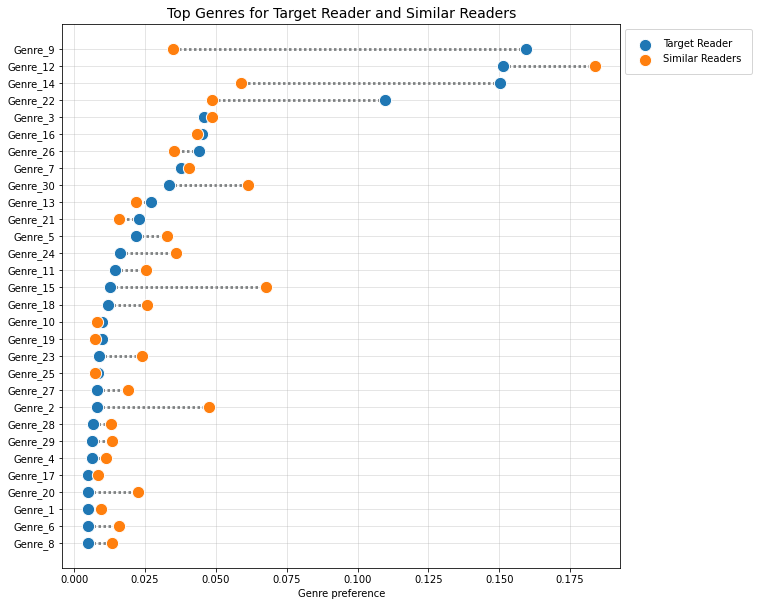

In [14]:
# Show top genres
plot_top_genres(sm_neighborhood_ratings, target_user_ratings)

In [15]:
# View most popular books among neighbors
neighbors_most_popular(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
118,Ready Player One,4.31,376328.0,2011.0,14.0%,https://www.goodreads.com/book/show/9969571-re...
209,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,9.3%,https://www.goodreads.com/book/show/7235533-th...
173,"The Hunger Games (The Hunger Games, #1)",4.34,4899965.0,2008.0,9.3%,https://www.goodreads.com/book/show/2767052-th...
42,Dark Matter,4.10,75794.0,2016.0,9.3%,https://www.goodreads.com/book/show/27833670-d...
185,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,7.0%,https://www.goodreads.com/book/show/186074.The...
182,The Martian,4.39,435440.0,2014.0,7.0%,https://www.goodreads.com/book/show/18007564-t...
12,All the Light We Cannot See,4.31,498685.0,2014.0,7.0%,https://www.goodreads.com/book/show/18143977-a...
104,"Old Man's War (Old Man's War, #1)",4.23,100702.0,2007.0,7.0%,https://www.goodreads.com/book/show/51964.Old_...
89,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,2011.0,7.0%,https://www.goodreads.com/book/show/8855321-le...
103,"Off to Be the Wizard (Magic 2.0, #1)",3.98,13834.0,2014.0,7.0%,https://www.goodreads.com/book/show/18616975-o...


In [16]:
# View highest rated books among similar readers
neighbors_top_rated(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
209,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
185,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,https://www.goodreads.com/book/show/186074.The...
175,The Josephine B Trilogy,4.45,132.0,2006.0,https://www.goodreads.com/book/show/1308176.Th...
163,"The Final Empire (Mistborn, #1)",4.43,216149.0,2006.0,https://www.goodreads.com/book/show/68428.The_...
7,A Night Without Stars,4.41,1758.0,2016.0,https://www.goodreads.com/book/show/28530221-a...
59,Gates of Fire: An Epic Novel of the Battle of ...,4.40,18299.0,2005.0,https://www.goodreads.com/book/show/1305.Gates...
182,The Martian,4.39,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
6,A Gentleman in Moscow,4.37,44419.0,2016.0,https://www.goodreads.com/book/show/29430012-a...
66,Homicide: A Year on the Killing Streets,4.37,10487.0,1991.0,https://www.goodreads.com/book/show/18956.Homi...
128,Salt to the Sea,4.36,44903.0,2016.0,https://www.goodreads.com/book/show/25614492-s...


In [17]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=sm_neighborhood_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    n_recs=15,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
9,The Josephine B Trilogy,4.45,132.0,https://www.goodreads.com/book/show/1308176.Th...
1,A Thousand Splendid Suns,4.34,835172.0,https://www.goodreads.com/book/show/128029.A_T...
7,The Emperor of All Maladies: A Biography of Ca...,4.29,49534.0,https://www.goodreads.com/book/show/7170627-th...
2,Bury My Heart at Wounded Knee: An Indian Histo...,4.21,41180.0,https://www.goodreads.com/book/show/76401.Bury...
11,The Red Tent,4.16,428809.0,https://www.goodreads.com/book/show/4989.The_R...
4,Patriotism,4.12,1869.0,https://www.goodreads.com/book/show/62795.Patr...
6,The Dream of a Ridiculous Man,4.07,4927.0,https://www.goodreads.com/book/show/329866.The...
10,The Picture of Dorian Gray,4.06,607145.0,https://www.goodreads.com/book/show/5297.The_P...
8,The Immortal Life of Henrietta Lacks,4.04,390601.0,https://www.goodreads.com/book/show/6493208-th...
12,The Tiger: A True Story of Vengeance and Survival,4.01,6156.0,https://www.goodreads.com/book/show/7624594-th...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
1,A Night Without Stars,4.41,1758.0,https://www.goodreads.com/book/show/28530221-a...
56,The Martian,4.39,435440.0,https://www.goodreads.com/book/show/18007564-t...
62,The Stand,4.34,449730.0,https://www.goodreads.com/book/show/149267.The...
26,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
64,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,17174.0,https://www.goodreads.com/book/show/32109569-w...
35,"Pandora's Star (Commonwealth Saga, #1)",4.24,1312.0,https://www.goodreads.com/book/show/6136470-pa...
31,"Old Man's War (Old Man's War, #1)",4.23,100702.0,https://www.goodreads.com/book/show/51964.Old_...
49,The Abyss Beyond Dreams,4.21,4944.0,https://www.goodreads.com/book/show/20697413-t...
27,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,https://www.goodreads.com/book/show/8855321-le...
5,Anathem,4.18,45672.0,https://www.goodreads.com/book/show/2845024-an...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
10,On Tyranny: Twenty Lessons from the Twentieth ...,4.29,9145.0,https://www.goodreads.com/book/show/33917107-o...
11,Our Revolution: A Future to Believe In,4.29,2430.0,https://www.goodreads.com/book/show/31741420-o...
6,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,11750.0,https://www.goodreads.com/book/show/22535480-e...
9,Hun Sen’s Cambodia,4.20,105.0,https://www.goodreads.com/book/show/21945075-h...
21,"Titan: The Life of John D. Rockefeller, Sr.",4.19,8970.0,https://www.goodreads.com/book/show/16121.Titan
3,"Blood Meridian, or the Evening Redness in the ...",4.18,72755.0,https://www.goodreads.com/book/show/394535.Blo...
20,The Sleepwalkers: How Europe Went to War in 1914,4.18,3830.0,https://www.goodreads.com/book/show/18669169-t...
15,Superforecasting: The Art and Science of Predi...,4.13,4876.0,https://www.goodreads.com/book/show/23995360-s...
17,"The Conservative Heart: How to Build a Fairer,...",4.13,564.0,https://www.goodreads.com/book/show/25723233-t...
7,Fuzzy Nation,4.10,17539.0,https://www.goodreads.com/book/show/9647532-fu...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
10,The Authoritarians,4.31,354.0,https://www.goodreads.com/book/show/1971601.Th...
8,Stories of Your Life and Others,4.27,17769.0,https://www.goodreads.com/book/show/223380.Sto...
13,The Hero With a Thousand Faces,4.24,18378.0,https://www.goodreads.com/book/show/588138.The...
2,Dear Data,4.22,227.0,https://www.goodreads.com/book/show/28465052-d...
5,Meditations,4.20,45727.0,https://www.goodreads.com/book/show/30659.Medi...
0,A Brief History of Time,4.13,173373.0,https://www.goodreads.com/book/show/3869.A_Bri...
12,"The Fabric of the Cosmos: Space, Time, and the...",4.11,24820.0,https://www.goodreads.com/book/show/22435.The_...
16,The Left Hand of Darkness,4.05,63749.0,https://www.goodreads.com/book/show/18423.The_...
14,The Hidden Reality: Parallel Universes and the...,4.05,12465.0,https://www.goodreads.com/book/show/8167094-th...
1,A Field Guide to Getting Lost,4.03,5251.0,https://www.goodreads.com/book/show/76479.A_Fi...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
5,Falling Upward: A Spirituality for the Two Hal...,4.24,4884.0,https://www.goodreads.com/book/show/9963483-fa...
2,Becoming Wise: An Inquiry into the Mystery and...,4.22,1683.0,https://www.goodreads.com/book/show/25894085-b...
4,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,1659.0,https://www.goodreads.com/book/show/5944774-de...
9,Imagining the Kingdom: How Worship Works,4.15,390.0,https://www.goodreads.com/book/show/15863575-i...
15,The Essential Dalai Lama: His Important Teachings,4.12,315.0,https://www.goodreads.com/book/show/237924.The...
16,The Obstacle Is the Way: The Timeless Art of T...,4.11,13544.0,https://www.goodreads.com/book/show/18668059-t...
7,How Will You Measure Your Life?,4.06,11938.0,https://www.goodreads.com/book/show/13425570-h...
8,If the Oceans Were Ink: An Unlikely Friendship...,4.02,792.0,https://www.goodreads.com/book/show/22320455-i...
14,The Course of Love,4.01,7488.0,https://www.goodreads.com/book/show/27845690-t...
1,A Year of Biblical Womanhood,3.94,6528.0,https://www.goodreads.com/book/show/13544022-a...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

#### 2.1 - Factorize User-Rating Matrix with SVD

In [18]:
# Choose neighborhood size for SVD
svd_neighborhood_ratings = lg_neighborhood_ratings

In [19]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"Neighborhood contains {svd_neighbor_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]

Neighborhood contains 11,719 books


In [20]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=15)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [21]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

In [22]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [23]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
7,The Martian,4.39,3.429059,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
18,Ready Player One,4.31,1.867428,376328.0,2011.0,https://www.goodreads.com/book/show/9969571-re...
20,The Name of the Wind (The Kingkiller Chronicle...,4.55,1.667410,416634.0,2007.0,https://www.goodreads.com/book/show/186074.The...
24,Brave New World,3.97,1.320558,1043619.0,1998.0,https://www.goodreads.com/book/show/5129.Brave...
26,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,1.212812,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
27,One Hundred Years of Solitude,4.04,1.183286,497852.0,2003.0,https://www.goodreads.com/book/show/320.One_Hu...
28,"The Hunger Games (The Hunger Games, #1)",4.34,1.150632,4899965.0,2008.0,https://www.goodreads.com/book/show/2767052-th...
29,Seveneves,3.98,1.132544,47286.0,2015.0,https://www.goodreads.com/book/show/22816087-s...
33,The Handmaid's Tale,4.07,1.039584,648783.0,1998.0,https://www.goodreads.com/book/show/38447.The_...
34,Dark Matter,4.10,1.033241,75794.0,2016.0,https://www.goodreads.com/book/show/27833670-d...


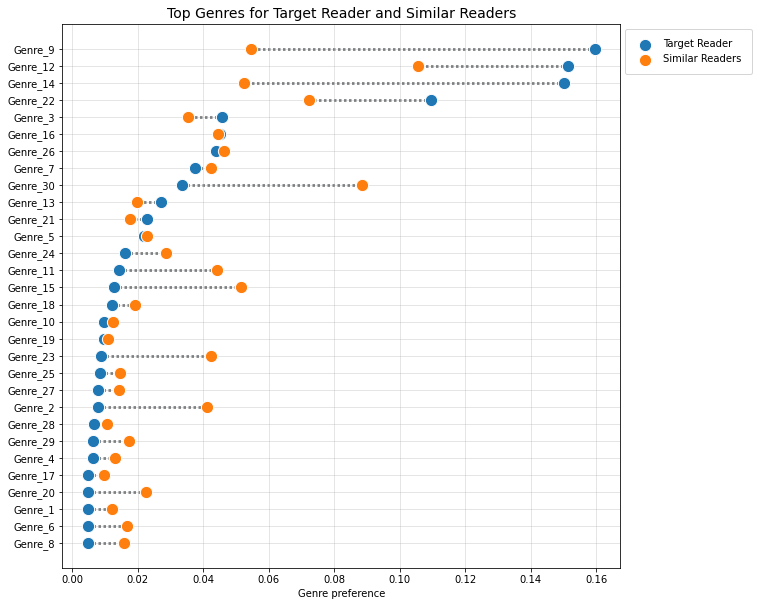

In [24]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [25]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
4337,The Martian,4.39,435440.0,2014.0,8.3%,https://www.goodreads.com/book/show/18007564-t...
2841,Ready Player One,4.31,376328.0,2011.0,8.3%,https://www.goodreads.com/book/show/9969571-re...
4403,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,5.4%,https://www.goodreads.com/book/show/186074.The...
4140,"The Hunger Games (The Hunger Games, #1)",4.34,4899965.0,2008.0,5.0%,https://www.goodreads.com/book/show/2767052-th...
3917,The Fault in Our Stars,4.26,2429317.0,2012.0,4.5%,https://www.goodreads.com/book/show/11870085-t...
649,Brave New World,3.97,1043619.0,1998.0,3.9%,https://www.goodreads.com/book/show/5129.Brave...
2107,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,2011.0,3.4%,https://www.goodreads.com/book/show/8855321-le...
348,"Ancillary Justice (Imperial Radch, #1)",3.97,40736.0,2013.0,3.4%,https://www.goodreads.com/book/show/17333324-a...
936,Dark Matter,4.10,75794.0,2016.0,3.4%,https://www.goodreads.com/book/show/27833670-d...
309,"American Gods (American Gods, #1)",4.11,379668.0,2005.0,3.2%,https://www.goodreads.com/book/show/4407.Ameri...


In [26]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
2682,Patrick O'Brian's Aubrey/Maturin Series,4.83,420.0,2010.0,https://www.goodreads.com/book/show/8432716-pa...
1134,ESV Study Bible,4.76,9036.0,2008.0,https://www.goodreads.com/book/show/5031805-es...
2241,Mark of the Lion Trilogy,4.76,9189.0,1998.0,https://www.goodreads.com/book/show/95602.Mark...
1037,Digger: The Complete Omnibus,4.72,392.0,2013.0,https://www.goodreads.com/book/show/19276094-d...
2972,Saga: Book One,4.70,4201.0,2014.0,https://www.goodreads.com/book/show/22078240-saga
1404,Free Verse,4.69,114.0,1991.0,https://www.goodreads.com/book/show/365331.Fre...
2973,Saga: Book Two,4.68,866.0,2017.0,https://www.goodreads.com/book/show/32926680-saga
3090,Sherlock Holmes: The Definitive Collection,4.68,240.0,2017.0,https://www.goodreads.com/book/show/34429916-s...
3952,The Fortress,4.67,1955.0,1970.0,https://www.goodreads.com/book/show/1679497.Th...
4979,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011.0,https://www.goodreads.com/book/show/9329354-th...


In [27]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
55,The Picture of Dorian Gray,4.06,607145.0,https://www.goodreads.com/book/show/5297.The_P...
98,A Thousand Splendid Suns,4.34,835172.0,https://www.goodreads.com/book/show/128029.A_T...
114,The Underground Railroad,4.03,86839.0,https://www.goodreads.com/book/show/30555488-t...
115,Les Misérables,4.14,519758.0,https://www.goodreads.com/book/show/24280.Les_...
121,On Writing: A Memoir of the Craft,4.31,135528.0,https://www.goodreads.com/book/show/10569.On_W...
125,The Godfather,4.36,259150.0,https://www.goodreads.com/book/show/22034.The_...
175,The Immortal Life of Henrietta Lacks,4.04,390601.0,https://www.goodreads.com/book/show/6493208-th...
206,"Unbroken: A World War II Story of Survival, Re...",4.39,504961.0,https://www.goodreads.com/book/show/8664353-un...
214,World War Z: An Oral History of the Zombie War,4.01,320129.0,https://www.goodreads.com/book/show/8908.World...
215,India After Gandhi: The History of the World's...,4.35,9652.0,https://www.goodreads.com/book/show/356824.Ind...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
7,The Martian,4.39,435440.0,https://www.goodreads.com/book/show/18007564-t...
40,Do Androids Dream of Electric Sheep?,4.08,229370.0,https://www.goodreads.com/book/show/7082.Do_An...
41,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,https://www.goodreads.com/book/show/8855321-le...
42,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,15139.0,https://www.goodreads.com/book/show/22733729-t...
47,"Binti (Binti, #1)",4.02,7945.0,https://www.goodreads.com/book/show/25667918-b...
57,"Old Man's War (Old Man's War, #1)",4.23,100702.0,https://www.goodreads.com/book/show/51964.Old_...
93,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,17174.0,https://www.goodreads.com/book/show/32109569-w...
101,"A Fire Upon the Deep (Zones of Thought, #1)",4.13,38809.0,https://www.goodreads.com/book/show/77711.A_Fi...
102,Childhood's End,4.09,89107.0,https://www.goodreads.com/book/show/414999.Chi...
116,"The Forever War (The Forever War, #1)",4.15,89663.0,https://www.goodreads.com/book/show/21611.The_...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
87,Elon Musk: Inventing the Future,4.24,63849.0,https://www.goodreads.com/book/show/22543496-e...
269,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,11750.0,https://www.goodreads.com/book/show/22535480-e...
281,"Red Notice: A True Story of High Finance, Murd...",4.35,10976.0,https://www.goodreads.com/book/show/22609522-r...
314,"No Place to Hide: Edward Snowden, the NSA, and...",4.08,8572.0,https://www.goodreads.com/book/show/18213403-n...
348,The Everything Store: Jeff Bezos and the Age o...,4.07,22546.0,https://www.goodreads.com/book/show/17660462-t...
404,Fuzzy Nation,4.10,17539.0,https://www.goodreads.com/book/show/9647532-fu...
408,Genghis Khan and the Making of the Modern World,4.01,26700.0,https://www.goodreads.com/book/show/93426.Geng...
421,The Code Book: The Science of Secrecy from Anc...,4.29,13196.0,https://www.goodreads.com/book/show/17994.The_...
431,Daemon (Daemon #1),4.17,9355.0,https://www.goodreads.com/book/show/6665847-da...
461,This Changes Everything: Capitalism vs. The Cl...,4.17,8066.0,https://www.goodreads.com/book/show/21913812-t...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
99,A Brief History of Time,4.13,173373.0,https://www.goodreads.com/book/show/3869.A_Bri...
104,Stories of Your Life and Others,4.27,17769.0,https://www.goodreads.com/book/show/223380.Sto...
111,Pride and Prejudice,4.25,2078406.0,https://www.goodreads.com/book/show/1885.Pride...
118,The Left Hand of Darkness,4.05,63749.0,https://www.goodreads.com/book/show/18423.The_...
165,"The Diamond Age: or, A Young Lady's Illustrate...",4.19,62866.0,https://www.goodreads.com/book/show/827.The_Di...
171,The Brothers Karamazov,4.31,158410.0,https://www.goodreads.com/book/show/4934.The_B...
219,The Grand Design,4.01,44203.0,https://www.goodreads.com/book/show/8520362-th...
229,The Unbearable Lightness of Being,4.08,209734.0,https://www.goodreads.com/book/show/9717.The_U...
260,"Gödel, Escher, Bach: An Eternal Golden Braid",4.29,32358.0,https://www.goodreads.com/book/show/24113.G_de...
285,The Hidden Reality: Parallel Universes and the...,4.05,12465.0,https://www.goodreads.com/book/show/8167094-th...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
60,Man's Search for Meaning,4.33,179906.0,https://www.goodreads.com/book/show/4069.Man_s...
216,The Subtle Art of Not Giving a F*ck: A Counter...,4.02,60032.0,https://www.goodreads.com/book/show/28257707-t...
250,The Prophet,4.23,145579.0,https://www.goodreads.com/book/show/2547.The_P...
266,Quiet: The Power of Introverts in a World That...,4.04,208008.0,https://www.goodreads.com/book/show/8520610-quiet
303,How Will You Measure Your Life?,4.06,11938.0,https://www.goodreads.com/book/show/13425570-h...
406,The Last Lecture,4.25,245804.0,https://www.goodreads.com/book/show/2318271.Th...
459,The Divine Conspiracy: Rediscovering Our Hidde...,4.24,8188.0,https://www.goodreads.com/book/show/173454.The...
541,The Challenge of Jesus: Rediscovering Who Jesu...,4.13,2053.0,https://www.goodreads.com/book/show/889083.The...
544,How God Became King: The Forgotten Story of th...,4.26,1289.0,https://www.goodreads.com/book/show/12968770-h...
545,"Simply Jesus: A New Vision of Who He Was, What...",4.21,2034.0,https://www.goodreads.com/book/show/11531546-s...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [28]:
# Choose neighborhood size for GD
gd_neighborhoodhood_ratings = med_neighborhood_ratings

In [29]:
# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"Neighborhood contains {gd_neighborhood_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

Neighborhood contains 4,474 books


In [30]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=15, steps=200, lr=0.0002, beta=0.01, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every n steps                  
        if (((step + 1) / (steps / 5)) % 1 == 0) | (step == 0): 
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, Loss: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 1.5
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [46]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=15, 
                                    lr=0.0006, 
                                    beta=0.001,
                                    decay=True, 
                                    steps=200, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, Loss: 19119.76, lr: 0.00060
Step: 40, Loss: 15415.30, lr: 0.00040
Step: 80, Loss: 13708.04, lr: 0.00027
Step: 120, Loss: 12844.21, lr: 0.00018
Step: 160, Loss: 12367.37, lr: 0.00012
Step: 200, Loss: 12087.75, lr: 0.00008


In [47]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)

# Narrow to top genres first
top_genres = pd.DataFrame(target_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))[0:5].index
top_genres = [int(tg[6:]) for tg in top_genres]

top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
0,Rally Cry (Lost Regiment #1),4.08,5.910930,1553.0,1990.0,https://www.goodreads.com/book/show/362138.Ral...
1,The Dog Stars,3.91,5.781350,34100.0,2012.0,https://www.goodreads.com/book/show/13330761-t...
2,Childhood's End,4.09,5.762490,89107.0,1953.0,https://www.goodreads.com/book/show/414999.Chi...
4,"Odd Thomas (Odd Thomas, #1)",3.94,5.714741,208258.0,2006.0,https://www.goodreads.com/book/show/14995.Odd_...
5,Jane Eyre,4.10,5.640979,1207986.0,1847.0,https://www.goodreads.com/book/show/10210.Jane...
7,"Going Clear: Scientology, Hollywood, and the P...",4.02,5.586881,26672.0,2013.0,https://www.goodreads.com/book/show/16142053-g...
11,Norwegian Wood,4.02,5.554572,189394.0,2000.0,https://www.goodreads.com/book/show/11297.Norw...
12,The Husband's Secret,3.92,5.522810,242884.0,2013.0,https://www.goodreads.com/book/show/17802724-t...
13,"The Conservative Heart: How to Build a Fairer,...",4.13,5.508168,564.0,2015.0,https://www.goodreads.com/book/show/25723233-t...
14,The Consequence of High Caliber (The Mako Shar...,4.19,5.505292,105.0,2014.0,https://www.goodreads.com/book/show/23718427-t...


In [48]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.9, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
17,The Winter of Our Discontent,3.99,28470.0,https://www.goodreads.com/book/show/4796.The_W...
20,John Adams,4.05,223171.0,https://www.goodreads.com/book/show/2203.John_...
34,"Unwind (Unwind, #1)",4.18,147134.0,https://www.goodreads.com/book/show/764347.Unwind
36,El camino de la autodependencia,3.94,576.0,https://www.goodreads.com/book/show/2440207.El...
39,The Fall,4.05,44207.0,https://www.goodreads.com/book/show/11991.The_...
47,City of Thieves,4.28,69955.0,https://www.goodreads.com/book/show/1971304.Ci...
66,Battle Lines: A Graphic History of the Civil War,4.25,197.0,https://www.goodreads.com/book/show/18490664-b...
84,"American Pastoral (The American Trilogy, #1)",3.91,39004.0,https://www.goodreads.com/book/show/11650.Amer...
85,"The Last Mughal: The Fall of a Dynasty: Delhi,...",4.11,4266.0,https://www.goodreads.com/book/show/124429.The...
104,You Don't Have to Say You Love Me,4.36,4478.0,https://www.goodreads.com/book/show/31420708-y...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
2,Childhood's End,4.09,89107.0,https://www.goodreads.com/book/show/414999.Chi...
16,Do Androids Dream of Electric Sheep?,4.08,229370.0,https://www.goodreads.com/book/show/7082.Do_An...
49,A Song for Lya: And Other Stories,3.95,959.0,https://www.goodreads.com/book/show/13498.A_So...
59,Vaster Than Empires and More Slow,3.95,175.0,https://www.goodreads.com/book/show/6337247-va...
61,"The Peace War (Across Realtime, #1)",3.95,4819.0,https://www.goodreads.com/book/show/167845.The...
77,Infinity Welcomes Careful Drivers (Red Dwarf #1),4.03,20134.0,https://www.goodreads.com/book/show/349090.Inf...
106,Nightfall,4.16,273.0,https://www.goodreads.com/book/show/18297094-n...
121,The Evolutionary Void,4.26,13729.0,https://www.goodreads.com/book/show/7438179-th...
149,Miniatures: The Very Short Fiction of John Scalzi,3.91,966.0,https://www.goodreads.com/book/show/31258177-m...
173,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
7,"Going Clear: Scientology, Hollywood, and the P...",4.02,26672.0,https://www.goodreads.com/book/show/16142053-g...
13,"The Conservative Heart: How to Build a Fairer,...",4.13,564.0,https://www.goodreads.com/book/show/25723233-t...
38,Thomas Jefferson: The Art of Power,3.98,19646.0,https://www.goodreads.com/book/show/13533740-t...
51,The Signal and the Noise: Why So Many Predicti...,3.97,27729.0,https://www.goodreads.com/book/show/13588394-t...
125,Buffett: The Making of an American Capitalist,4.24,6881.0,https://www.goodreads.com/book/show/1155.Buffett
187,The Richest Man in Babylon,4.23,52607.0,https://www.goodreads.com/book/show/1052.The_R...
197,Twitter and Tear Gas: The Power and Fragility ...,4.31,157.0,https://www.goodreads.com/book/show/32714239-t...
235,The Everything Store: Jeff Bezos and the Age o...,4.07,22546.0,https://www.goodreads.com/book/show/17660462-t...
268,Imperial Life in the Emerald City: Inside Iraq...,4.01,4168.0,https://www.goodreads.com/book/show/22121.Impe...
289,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,11750.0,https://www.goodreads.com/book/show/22535480-e...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
15,The Beginning of Infinity: Explanations That T...,4.08,2697.0,https://www.goodreads.com/book/show/10483171-t...
32,Xeelee: Endurance,3.99,111.0,https://www.goodreads.com/book/show/25620065-x...
42,Ethics in the Real World: 86 Brief Essays on T...,3.92,412.0,https://www.goodreads.com/book/show/30272030-e...
46,By His Bootstraps,3.99,757.0,https://www.goodreads.com/book/show/13101981-b...
55,A Room of One's Own,4.10,61613.0,https://www.goodreads.com/book/show/18521.A_Ro...
113,VALIS and Later Novels,4.10,391.0,https://www.goodreads.com/book/show/5328062-va...
114,Cosmos,4.35,79680.0,https://www.goodreads.com/book/show/55030.Cosmos
196,Fermat's Enigma: The Epic Quest to Solve the W...,4.22,16113.0,https://www.goodreads.com/book/show/38412.Ferm...
214,The Theory of Everything: The Origin and Fate ...,4.11,6604.0,https://www.goodreads.com/book/show/449573.The...
215,Pale Blue Dot: A Vision of the Human Future in...,4.32,20464.0,https://www.goodreads.com/book/show/61663.Pale...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
22,The Pale King,3.95,11230.0,https://www.goodreads.com/book/show/9443405-th...
56,Everywhere Present: Christianity in a One-Stor...,4.40,118.0,https://www.goodreads.com/book/show/10640233-e...
68,Comfortable with Uncertainty: 108 Teachings on...,4.35,3156.0,https://www.goodreads.com/book/show/108829.Com...
83,Letters to a Young Contrarian,4.14,6756.0,https://www.goodreads.com/book/show/503150.Let...
108,We Should All Be Feminists,4.47,51354.0,https://www.goodreads.com/book/show/22738563-w...
118,A Manual for Creating Atheists,3.95,1247.0,https://www.goodreads.com/book/show/17937621-a...
126,The Creative Habit: Learn It and Use It for Life,3.99,13741.0,https://www.goodreads.com/book/show/254799.The...
170,"A Canticle for Leibowitz (St. Leibowitz, #1)",3.97,840.0,https://www.goodreads.com/book/show/673656.A_C...
241,Citizen: An American Lyric,4.30,15270.0,https://www.goodreads.com/book/show/20613761-c...
257,Western Muslims and the Future of Islam,4.12,385.0,https://www.goodreads.com/book/show/524202.Wes...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
64,Lessons in Mastery,4.27,488.0,https://www.goodreads.com/book/show/82063.Less...
134,Rework,3.93,93101.0,https://www.goodreads.com/book/show/6732019-re...
163,Clean Code: A Handbook of Agile Software Craft...,4.37,7718.0,https://www.goodreads.com/book/show/3735293-cl...
164,MONEY Master the Game: 7 Simple Steps to Finan...,3.94,5821.0,https://www.goodreads.com/book/show/23014006-m...
195,The Anxiety and Phobia Workbook,4.16,1380.0,https://www.goodreads.com/book/show/8527134-th...
202,Algorithms to Live By: The Computer Science of...,4.16,4639.0,https://www.goodreads.com/book/show/25666050-a...
323,Writing to Learn: How to Write--And Think--Cle...,3.96,423.0,https://www.goodreads.com/book/show/585474.Wri...
331,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
367,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,https://www.goodreads.com/book/show/10127019-t...
392,"Number Talks, Grades K-5: Helping Children Bui...",4.43,214.0,https://www.goodreads.com/book/show/9895900-nu...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
5,Jane Eyre,4.10,1207986.0,https://www.goodreads.com/book/show/10210.Jane...
37,"Promise of Blood (Powder Mage, #1)",4.16,22179.0,https://www.goodreads.com/book/show/15790883-p...
71,The Emperor's Blades (Chronicle of the Unhewn ...,4.15,20726.0,https://www.goodreads.com/book/show/17910124-t...
152,One Flew Over the Cuckoo's Nest,4.19,498475.0,https://www.goodreads.com/book/show/332613.One...
185,"Dancer's Lament (Path to Ascendancy, #1)",4.45,1085.0,https://www.goodreads.com/book/show/25480364-d...
228,Dawn (Legend of the Galactic Heroes #1),4.06,418.0,https://www.goodreads.com/book/show/25986983-dawn
269,Mr. Midshipman Hornblower,4.13,8684.0,https://www.goodreads.com/book/show/84748.Mr_M...
274,"Kushiel's Scion (Imriel's Trilogy, #1)",4.18,16556.0,https://www.goodreads.com/book/show/153007.Kus...
302,The Talisman Ring,3.97,4837.0,https://www.goodreads.com/book/show/32108.The_...
324,"The Crystal Cave (Arthurian Saga, #1)",4.12,35104.0,https://www.goodreads.com/book/show/82192.The_...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
60,"The Art of Asking; or, How I Learned to Stop W...",3.97,20606.0,https://www.goodreads.com/book/show/20980987-t...
63,Humans of New York: Stories,4.50,12833.0,https://www.goodreads.com/book/show/24019187-h...
72,You're Never Weird on the Internet,4.14,29419.0,https://www.goodreads.com/book/show/23705512-y...
81,Duino Elegies,4.44,4976.0,https://www.goodreads.com/book/show/53111.Duin...
130,"Voice from the Edge, vol 1: I Have No Mouth an...",4.18,177.0,https://www.goodreads.com/book/show/1231563.Vo...
131,An Ideal Husband,4.03,30337.0,https://www.goodreads.com/book/show/5296.An_Id...
226,Psychovertical,4.24,304.0,https://www.goodreads.com/book/show/5404376-ps...
254,The Color Purple,4.17,380851.0,https://www.goodreads.com/book/show/11486.The_...
261,Save the Cat!: The Last Book on Screenwriting ...,4.05,7172.0,https://www.goodreads.com/book/show/49464.Save...
369,Shrill,4.22,193.0,https://www.goodreads.com/book/show/31423180-s...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
73,"Penric's Demon (Penric and Desdemona, #1)",4.21,3391.0,https://www.goodreads.com/book/show/25791216-p...
96,The Waste Lands,4.24,121199.0,https://www.goodreads.com/book/show/34084.The_...
99,The Legacy Human (Singularity #1),4.06,270.0,https://www.goodreads.com/book/show/25052612-t...
100,Station Eleven,4.02,166920.0,https://www.goodreads.com/book/show/20170404-s...
260,The Heart of a Dog,4.14,539.0,https://www.goodreads.com/book/show/236592.The...
282,Ghostwritten,4.06,18254.0,https://www.goodreads.com/book/show/6819.Ghost...
337,Lady Macbeth of Mtsensk,3.95,1938.0,https://www.goodreads.com/book/show/58043.Lady...
346,Every Shallow Cut,3.93,344.0,https://www.goodreads.com/book/show/9663468-ev...
357,"Under Heaven (Under Heaven, #1)",4.13,8408.0,https://www.goodreads.com/book/show/7139892-un...
374,The Snow Child,3.95,74041.0,https://www.goodreads.com/book/show/11250053-t...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,ratings_count,url
116,During the Dance,4.35,525.0,https://www.goodreads.com/book/show/23163065-d...
147,At the Mouth of the River of Bees: Stories,4.06,1401.0,https://www.goodreads.com/book/show/12970063-a...
239,The Garden of Forking Paths,4.40,1326.0,https://www.goodreads.com/book/show/10438328-t...
256,The Star,4.11,706.0,https://www.goodreads.com/book/show/13598725-t...
275,The Complete Works of H.P. Lovecraft,4.34,9733.0,https://www.goodreads.com/book/show/11851522-t...
297,"Our Ancestors: The Cloven Viscount, The Baron ...",4.28,810.0,https://www.goodreads.com/book/show/9806.Our_A...
377,Stephen Hawking's a Brief History of Time: A R...,4.10,315.0,https://www.goodreads.com/book/show/17352.Step...
465,E não sobrou nenhum,4.23,139.0,https://www.goodreads.com/book/show/28093104-e...
500,The Paper Menagerie,4.37,2476.0,https://www.goodreads.com/book/show/13501210-t...
663,The Sheltering Sky,3.92,16812.0,https://www.goodreads.com/book/show/243598.The...


_____

